In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import scipy.stats as st
import matplotlib.colors as cl

from tqdm.notebook import tqdm

### Fix directories

data_dir = "../data/initial database/output" #path to project folder

os.chdir(data_dir) #Select the project directory

### Import the data from the csv files

def select_directory(sample, file_name = "compounds", part = 1):
    """Returns the file directory corresponding to the file_name.csv file in the folder corresponding to the given sample
    (DiAcids, Fallopia, Ruthenium or Ruthenium2).
    
    the input part indicates the subfolder in which it is stored (pt1 or pt2)."""
    return data_dir + "/" + sample + "/pt" + str(part) + "/" + file_name + ".csv"

def df_from_csv(directory):
    """Extracts the csv file of the file contained in the directory and stores it in a pandas dataframe."""
    with open(directory) as file:
        return pd.read_csv(file)

#Convert the data into pandas dataframes and compute intratios.

sample_names = ["DiAcids", "Fallopia", "Ruthenium", "Ruthenium2"]

data = pd.DataFrame({"compounds" : [df_from_csv(select_directory(sample)) for sample in sample_names],
                     "peaks" : [df_from_csv(select_directory(sample, file_name = "ms2_peaks")) for sample in sample_names],
                     "spectra" : [df_from_csv(select_directory(sample, file_name = "ms2_spectra")) for sample in sample_names]
                    }, index = sample_names)

def peaks_in_list(sample):
    """Returns a dataframe indexed by spectrum_id with entries lists of mz, list of
    intensities and sum of intensities of the ms2 peaks corresponding to this spectrum id."""
    
    groups = data["peaks"][sample].groupby(["spectrum_id"])
    df = groups.agg(list)
    
    return df.loc[:,["mz", "intensity"]]

list_format_sp = pd.Series([peaks_in_list(sample) for sample in sample_names], index = sample_names)

def get_spectrum(sample, spectrum_id):
    """Select a spectrum in the list_format_sp dataframe."""
    return pd.Series(list_format_sp[sample].intensity[spectrum_id], index = list_format_sp[sample].mz[spectrum_id], dtype = float)

def display(spectrum):
    x = spectrum.index
    plt.bar(x, spectrum, width = .5)
    plt.yscale("log")
    
def make_table(spectrum_id, sample = ["Fallopia", "Fallopia"]):
    """Make a contingency table out of the two spectra sp1 and sp2. Only consider peaks that are in both spectra.
    
    Input should be in the following form
    
    sample : a couple of sample names ("Fallopia", "DiAcids", "Ruthenium" or "Ruthenium2") ;
    spectrum_id : a couple of spectrum_id of the corresponding sample.
    
    The output is a 2 * d contingency tables containing the intensities of the selected peaks, where d is the number of selected peaks in each spectrum.    
    """
    
    #Extract the spectra as table with two columns, mz and intensity.
    sp1 = pd.DataFrame({"mz" : list_format_sp[sample[0]]["mz"][spectrum_id[0]],
                        "intensity" : list_format_sp[sample[0]]["intensity"][spectrum_id[0]]
                       })
    
    sp2 = pd.DataFrame({"mz" : list_format_sp[sample[1]]["mz"][spectrum_id[1]],
                        "intensity" : list_format_sp[sample[1]]["intensity"][spectrum_id[1]]
                       })
    
    #Initialization of the rows of the output table.
    row1, row2 = [], []
    
    k1, k2 = len(sp1), len(sp2)
    
    #Indices running through the mz list.
    i, j = 0, 0
    while i < k1 and j < k2:
        
        mz1, mz2 = sp1.mz[i], sp2.mz[j]
        if abs(mz1 - mz2) < 1e-5 * (mz1 + mz2) / 2: #Machine precision is 10ppm.
            #if the peaks have similar mz, their intensities are stored in row1 and row2.
            row1.append(sp1.intensity[i])
            row2.append(sp2.intensity[j])
            i += 1
            j += 1
        
        #If the mz are distinct, the index corresponding to the smallest mz moves on to the next one (the mz are sorted in incresasing order in the sp_i.mz lists)
        elif sp1.mz[i] < sp2.mz[j]:
            i += 1
            
        else :
            j += 1
            
    return np.array([row1, row2])



In [2]:
pd.set_option("display.max_rows", 200)

#Rename the dataframe to work with.
peaks = data["peaks"]["Fallopia"]
spectra = data["spectra"]["Fallopia"]
compounds = data["compounds"]["Fallopia"]


compounds.index = compounds["compound_id"]

spid_count_by_cid = spectra.groupby("compound_id")["spectrum_id"].count()
all_cid = spid_count_by_cid[spid_count_by_cid > 1].index
nb_cid = len(all_cid) #This is 794. There are 841 compound ids but only 794 have at least two spectra.

#First separate the compounds into a training set of size 320 and an evaluating set of size 80.
#This needs to be done so that there is enough pairs of compound id with the same molecular weight in the evaluation set.

#Create a data frame with columns compound id and parentmz rounded to the third decimal, sorted by parentmz.
spectra_by_cid = pd.DataFrame((1000 * spectra.groupby("compound_id")["parent_mz"].first().sort_values()).apply(int))
spectra_by_cid["compound_id"] = spectra_by_cid.index

#Aggregate the compound id with same parent mz in lists and select the lists of length > 1.
cid_by_pmz = spectra_by_cid.groupby("parent_mz")["compound_id"].agg(list)
comparable_cid = cid_by_pmz[np.array([len(x) for x in cid_by_pmz]) > 1]

len_comparable = len(comparable_cid)
comparable_cid.index = range(len_comparable)

#Select at random some of those list, amounting to around 280 cid (~ 400/794 of the comparable compounds id).
nb_of_lists = 50
nb_of_compounds = 0
while nb_of_compounds < 279:
    seed = 3177606399
    np.random.seed(seed)
    lst_of_indexes = np.random.choice(len_comparable, nb_of_lists, replace = False)
    nb_of_compounds = sum([len(x) for x in comparable_cid[lst_of_indexes]])
    nb_of_lists += 1

#From those ~280 cid, select at random ~ 56 of them
nb_of_lists = 10
nb_of_compounds = 0
while nb_of_compounds < 55:
    nb_of_lists += 1
    lst_of_eval_indexes = lst_of_indexes[:nb_of_lists] #lst_of_indexes is already randomly shuffled.
    nb_of_compounds = sum([len(x) for x in comparable_cid[lst_of_eval_indexes]])
    
eval_cid_flat = []
for i in lst_of_eval_indexes:
    eval_cid_flat += comparable_cid[i] #Evaluating members of the comparable cid.

training_cid_flat = []
for i in lst_of_indexes[nb_of_lists:]:
    training_cid_flat += comparable_cid[i] #Training members of the comparable cid.


#Now, add non-comparable indexes in both the training and the evaluating sets, to a total set of 400 compound ids
#Divided into 80 % for training and 20 % for evaluating, with fraction of comparable cid in each subset roughly equal to the
#fraction of comparable cid in the total set.

comparable_cid_flat = []
for lst in comparable_cid:
    comparable_cid_flat += lst

not_comparable_cid = np.array(all_cid)[np.logical_not([x in comparable_cid_flat for x in all_cid])]


seed = 2312570194
np.random.seed(seed)
random_not_comparable_cid = list(np.random.choice(not_comparable_cid,
                                                  400 - len(training_cid_flat) - len(eval_cid_flat),
                                                  replace = False
                                                 ))
missing_in_eval = 80 - len(eval_cid_flat)
eval_cid_flat += random_not_comparable_cid[:missing_in_eval] #Complete the evaluation set to 80 compound ids.
training_cid_flat += random_not_comparable_cid[missing_in_eval:] #Complete the training set to 320.

#Recap :
#eval_cid_flat is the list of compound ids in the evaluating set
#training_cid_flat is the list of compound ids in the training set

#comparable_cid is a series containing lists of cid having the same molecular weight.
#lst_of_eval_indexes is the list of indexes of comparables cid corresponding of the evaluating set for power testing
#Note : power testing is basically evaluating type 2 error, ie the proportion of false negative. Evaluating it can only be done
#on data labelled as negative, which here is spectra from different molecules having the same molecular weight. This is why
#preparing an evaluating set containing a fair amount of pairs of comparable compound ids is important (comparable means having
#the same molecular weight).

In [3]:
folder_directory = "../data/experiments/experiment 1/"

#Getting the tables back from the csv files.
training = pd.read_csv(folder_directory + "training_info.csv")
eval_alpha = pd.read_csv(folder_directory + "eval_alpha_info.csv")
eval_beta = pd.read_csv(folder_directory + "eval_beta_info.csv")

df = pd.read_csv(folder_directory + "training_tables.csv")
flat_tables = df.groupby("tb_index")["intensity"].agg(list).apply(np.array)
tables = [tb.reshape(2, len(tb) // 2) for tb in flat_tables]
nb_col = [len(tb[0]) for tb in tables]

training["tables"] = tables
training["nb_col"] = nb_col

df = pd.read_csv(folder_directory + "eval_alpha.csv")
flat_tables = df.groupby("tb_index")["intensity"].agg(list).apply(np.array)
tables = [tb.reshape(2, len(tb) // 2) for tb in flat_tables]
nb_col = [len(tb[0]) for tb in tables]

eval_alpha["tables"] = tables
eval_alpha["nb_col"] = nb_col

df = pd.read_csv(folder_directory + "eval_beta.csv")
flat_tables = df.groupby("tb_index")["intensity"].agg(list).apply(np.array)
tables = [tb.reshape(2, len(tb) // 2) for tb in flat_tables]
nb_col = [len(tb[0]) for tb in tables]

eval_beta["tables"] = tables
eval_beta["nb_col"] = nb_col

training_beta = pd.read_csv(folder_directory + "training_beta_info.csv")

df = pd.read_csv(folder_directory + "training_tables_beta.csv")
flat_tables = df.groupby("tb_index")["intensity"].agg(list).apply(np.array)
tables = [tb.reshape(2, len(tb) // 2) for tb in flat_tables]
nb_col = [len(tb[0]) for tb in tables]

training_beta["tables"] = tables
training_beta["nb_col"] = nb_col

In [4]:
#Function for computing the log-likelihood statistic in the multinomial model.

def ml_stat(table):
    """Given a contingency table, compute the statistic of the maximum likelihood
    for a test of independance between rows and columns, given by the formula
    T_ML = 2 * sum_{i, j} table_{i, j} log(table_[i, j] / m_{i, j})
    where m_{i, j} = (sum of row i) * (sum of column j) / (total sum of the table).
    
    The table should not contain non-positive values."""
    
    #Number of rows and columns of the table.
    r, c = table.shape
    
    #Compute the sums of the columns.
    col_sums = np.sum(table, axis = 0)

    #Compute the sums of the rows and stores them as a column vector.
    row_sums = np.expand_dims(np.sum(table, axis = 1), 1)
    
    #Total sum.
    total = np.sum(row_sums)
    
    #Compute the m_{i, j}.
    m = np.multiply(row_sums, col_sums) / total
    
    #Returns the result using the formula.
    return 2 * np.sum(table * np.log(table / m))

In [5]:
#Functions for computing maximum likelihood statistic in the Dirichlet-multinomial model.

from scipy.special import betaln

def log_likelihood(row, theta, phi):
    """Computes the log likelihood of a Dirichlet multinomial distribution for data row and parameters theta and phi."""
    res = 0
    for j in range(len(row)):
        res -= betaln(row[j], theta[j] / phi)
    return res

def L1_moments(row, phi):
    """Estimate the maximum likelihood under the alternative hypothesis with moments estimators as parameter for theta."""
    return log_likelihood(row, row /np.sum(row), phi)

def L0_moments(table, phi):
    """Estimate the maximum likelihood under the null hypothesis with moments estimators as parameter for theta."""
    #n_{1, +} and n_{2, +}
    n1, n2 = np.sum(table[0]), np.sum(table[1])
    theta = np.array([(table[0][j] + table[1][j]) / (n1 + n2) for j in range(len(table[0]))])
    return log_likelihood(table[0], theta, phi) + log_likelihood(table[1], theta, phi) 

def L0_other_moments(table, phi):
    """Estimate the maximum likelihood under the null hypothesis with moments estimators as parameter for theta."""
    #n_{1, +} and n_{2, +}
    n1, n2 = np.sum(table[0]), np.sum(table[1])
    theta = np.array([(n1 * table[0][i] + n2 * table[1][i]) / (n1 ** 2 + n2 ** 2) for i in range(len(table[0]))])
    return log_likelihood(table[0], theta, phi) + log_likelihood(table[1], theta, phi) 

def stat_DMN_moments(table, phi):
    """Compute an estimated likelihood statistic using the previous functions for a given contingency table."""
    return 2 * (L1_moments(table[0], phi) + L1_moments(table[1], phi) - L0_moments(table, phi))


In [6]:
#The methodology for training a value of phi and a threshold is the following : Give a power that we would like to reach for the
#test, then among the tables in training_beta find the threshold realizing that power for the lowest type I error possible
#by adjusting the parameter phi.

def type1(nb_col, phi, power):
    """Given a number of columns, a parameter phi and a power, learns a threshold th that realizes an error of type II of
    1 - power in the training set, and returns the associated type I error."""
    dmn_diff = pd.Series([stat_DMN_moments(tb, phi)
                        for tb in training_beta["tables"][training_beta["nb_col"] == nb_col]
                       ])
    dmn_same = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in training["tables"][training["nb_col"] == nb_col]
                         ])
    
    th = dmn_diff.quantile(1 -power)
    
    return th, np.sum(dmn_same > th) / len(dmn_same), len(dmn_same)

In [7]:
def find_phi(nb_col, power):
    list_th = []
    list_alpha = []
    list_nalpha = []
    lst_phi = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

    for phi in lst_phi:

        th, alpha, nalpha = type1(nb_col, phi, power)
        list_th.append(th)
        list_alpha.append(alpha)
        list_nalpha.append(nalpha)
    
    i = list_alpha.index(min(list_alpha))
    
    return lst_phi[i], list_th[i], list_alpha[i], list_nalpha[i]

    

In [8]:
def ev(nb_col, phi, th):
    dmn_diff = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in eval_beta["tables"][eval_beta["nb_col"] == nb_col]
                         ])
    
    dmn_same = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in eval_alpha["tables"][eval_alpha["nb_col"] == nb_col]
                         ])
    
    return np.sum(dmn_diff > th) / len(dmn_diff), np.sum(dmn_same > th) / len(dmn_same), len(dmn_diff), len(dmn_same)

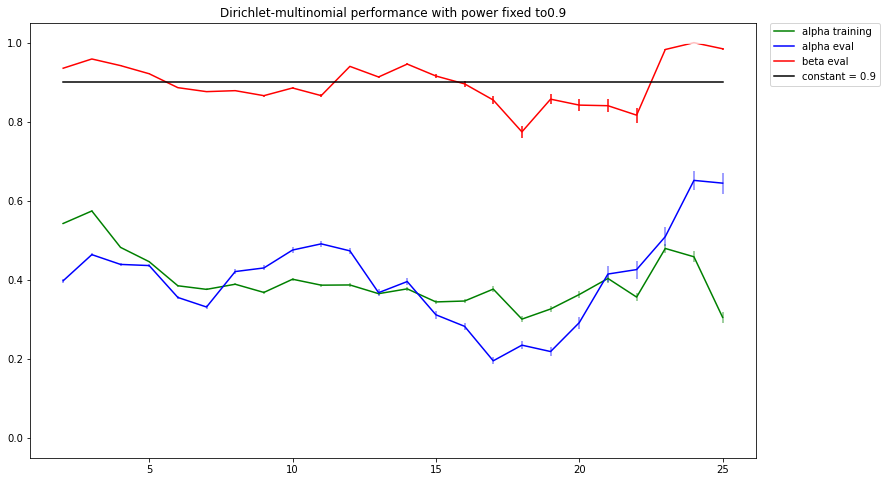

In [10]:
max_col = 26

power = 0.9

plt.figure(figsize = (13, 8))
plt.rcParams["figure.dpi"] = 200

x = np.arange(2, max_col)

type1_training = []
type1_eval = []
type2_eval = []

for nb_col in x:
    phi, th, alpha0, nalpha0 = find_phi(nb_col, power)
    
    beta, alpha, nbeta, nalpha = ev(nb_col, phi, th)
    
    plt.errorbar(nb_col, alpha0, xerr = 0, yerr = alpha0 * (1 - alpha0) / np.sqrt(nalpha0), color = "green", alpha = .5)
    plt.errorbar(nb_col, alpha, xerr = 0, yerr = alpha * (1 - alpha) / np.sqrt(nalpha), color = "blue", alpha = .5)
    plt.errorbar(nb_col, beta, xerr = 0, yerr = beta * (1 - beta) / np.sqrt(nbeta), color = "red")
    
    type1_training.append(alpha0)
    type1_eval.append(alpha)
    type2_eval.append(beta)
    
plt.plot(x, type1_training, color = "green", label = "alpha training")
plt.plot(x, type1_eval, color = "blue", label = "alpha eval")
plt.plot(x, type2_eval, color = "red", label = "beta eval")

plt.plot(x, (max_col - 2) * [0], color = "lightgrey")
plt.plot(x, (max_col - 2) * [1], color = "lightgrey")
plt.plot(x, (max_col - 2) * [power], color = "black", label = "constant = " + str(power))

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.title("Dirichlet-multinomial performance with power fixed to" + str(power))
plt.show()

In [17]:
def type1_flat(nb_col, phi, power):
    """Given a number of columns, a parameter phi and a power, learns a threshold th that realizes an error of type II of
    1 - power in the training set, and returns the associated type I error, by using weighted quantiles."""
    dmn_diff = pd.Series([stat_DMN_moments(tb, phi)
                        for tb in training_beta["tables"][training_beta["nb_col"] == nb_col]
                       ])
    
    count_by_cid = training_beta.groupby("str_compound_id")["tables"].count()
    dmn_diff_weights = pd.Series([1 / count_by_cid[cid] for cid in training_beta["str_compound_id"][training_beta["nb_col"] == nb_col]])
    total_weight = dmn_diff_weights.sum()
    
    sort_by_stat = dmn_diff.sort_values().index
    
    i = 0
    s = 0
    max_s = (1 - power) * total_weight
    while s < max_s:
        s += dmn_diff_weights[sort_by_stat[i]]
        i += 1
    
    th = (dmn_diff[sort_by_stat[i]] + dmn_diff[sort_by_stat[i - 1]]) / 2
    
    dmn_same = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in training["tables"][training["nb_col"] == nb_col]
                         ])
    count_by_cid = training.groupby("compound_id")["tables"].count()
    dmn_same_weights = pd.Series([1 / count_by_cid[cid] for cid in training["compound_id"][training["nb_col"] == nb_col]])
    total_same_weight = dmn_same_weights.sum()
    
    return th, dmn_same_weights[dmn_same > th].sum() / total_same_weight, total_same_weight
    
def type1_flat2(nb_col, phi, power):
    """Given a number of columns, a parameter phi and a power, learns a threshold th that realizes an error of type II of
    1 - power in the training set, and returns the associated type I error, by using weighted quantiles."""
    dmn_diff = pd.Series([stat_DMN_moments(tb, phi)
                        for tb in training_beta["tables"][training_beta["nb_col"] == nb_col]
                       ])
    
    count_by_cid = training_beta.groupby("str_compound_id")["tables"].count()
    dmn_diff_weights = pd.Series([1 /np.sqrt(count_by_cid[cid]) for cid in training_beta["str_compound_id"][training_beta["nb_col"] == nb_col]])
    total_weight = dmn_diff_weights.sum()
    
    sort_by_stat = dmn_diff.sort_values().index
    
    i = 0
    s = 0
    max_s = (1 - power) * total_weight
    while s < max_s:
        s += dmn_diff_weights[sort_by_stat[i]]
        i += 1
    
    th = (dmn_diff[sort_by_stat[i]] + dmn_diff[sort_by_stat[i - 1]]) / 2
    
    dmn_same = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in training["tables"][training["nb_col"] == nb_col]
                         ])
    count_by_cid = training.groupby("compound_id")["tables"].count()
    dmn_same_weights = pd.Series([1 / np.sqrt(count_by_cid[cid]) for cid in training["compound_id"][training["nb_col"] == nb_col]])
    total_same_weight = dmn_same_weights.sum()
    
    
    return th, dmn_same_weights[dmn_same > th].sum() / total_same_weight, total_same_weight

def find_phi_flat(nb_col, power):
    list_th = []
    list_alpha = []
    list_nalpha = []
    lst_phi = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

    for phi in lst_phi:

        th, alpha, nalpha = type1_flat(nb_col, phi, power)
        list_th.append(th)
        list_alpha.append(alpha)
        list_nalpha.append(nalpha)
    
    i = list_alpha.index(min(list_alpha))
    
    return lst_phi[i], list_th[i], list_alpha[i], list_nalpha[i]

def find_phi_flat2(nb_col, power):
    list_th = []
    list_alpha = []
    list_nalpha = []
    lst_phi = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

    for phi in lst_phi:

        th, alpha, nalpha = type1_flat2(nb_col, phi, power)
        list_th.append(th)
        list_alpha.append(alpha)
        list_nalpha.append(nalpha)
    
    i = list_alpha.index(min(list_alpha))
    
    return lst_phi[i], list_th[i], list_alpha[i], list_nalpha[i]

def ev_flat(nb_col, phi, th):
    dmn_diff = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in eval_beta["tables"][eval_beta["nb_col"] == nb_col]
                         ])
    count_by_cid = eval_beta.groupby("str_compound_id")["tables"].count()
    dmn_diff_weights = pd.Series([1 / count_by_cid[cid] for cid in eval_beta["str_compound_id"][eval_beta["nb_col"] == nb_col]])
    total_diff_weight = dmn_diff_weights.sum()
    
    dmn_same = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in eval_alpha["tables"][eval_alpha["nb_col"] == nb_col]
                         ])
    count_by_cid = eval_alpha.groupby("compound_id")["tables"].count()
    dmn_same_weights = pd.Series([1 / count_by_cid[cid] for cid in eval_alpha["compound_id"][eval_alpha["nb_col"] == nb_col]])
    total_same_weight = dmn_same_weights.sum()
    
    
    return dmn_diff_weights[dmn_diff > th].sum() / total_diff_weight, dmn_same_weights[dmn_same > th].sum() / total_same_weight, total_diff_weight, total_same_weight

def ev_flat2(nb_col, phi, th):
    dmn_diff = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in eval_beta["tables"][eval_beta["nb_col"] == nb_col]
                         ])
    count_by_cid = eval_beta.groupby("str_compound_id")["tables"].count()
    dmn_diff_weights = pd.Series([1 / np.sqrt(count_by_cid[cid]) for cid in eval_beta["str_compound_id"][eval_beta["nb_col"] == nb_col]])
    total_diff_weight = dmn_diff_weights.sum()
    
    dmn_same = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in eval_alpha["tables"][eval_alpha["nb_col"] == nb_col]
                         ])
    count_by_cid = eval_alpha.groupby("compound_id")["tables"].count()
    dmn_same_weights = pd.Series([1 / np.sqrt(count_by_cid[cid]) for cid in eval_alpha["compound_id"][eval_alpha["nb_col"] == nb_col]])
    total_same_weight = dmn_same_weights.sum()
    
    
    return dmn_diff_weights[dmn_diff > th].sum() / total_diff_weight, dmn_same_weights[dmn_same > th].sum() / total_same_weight, total_diff_weight, total_same_weight

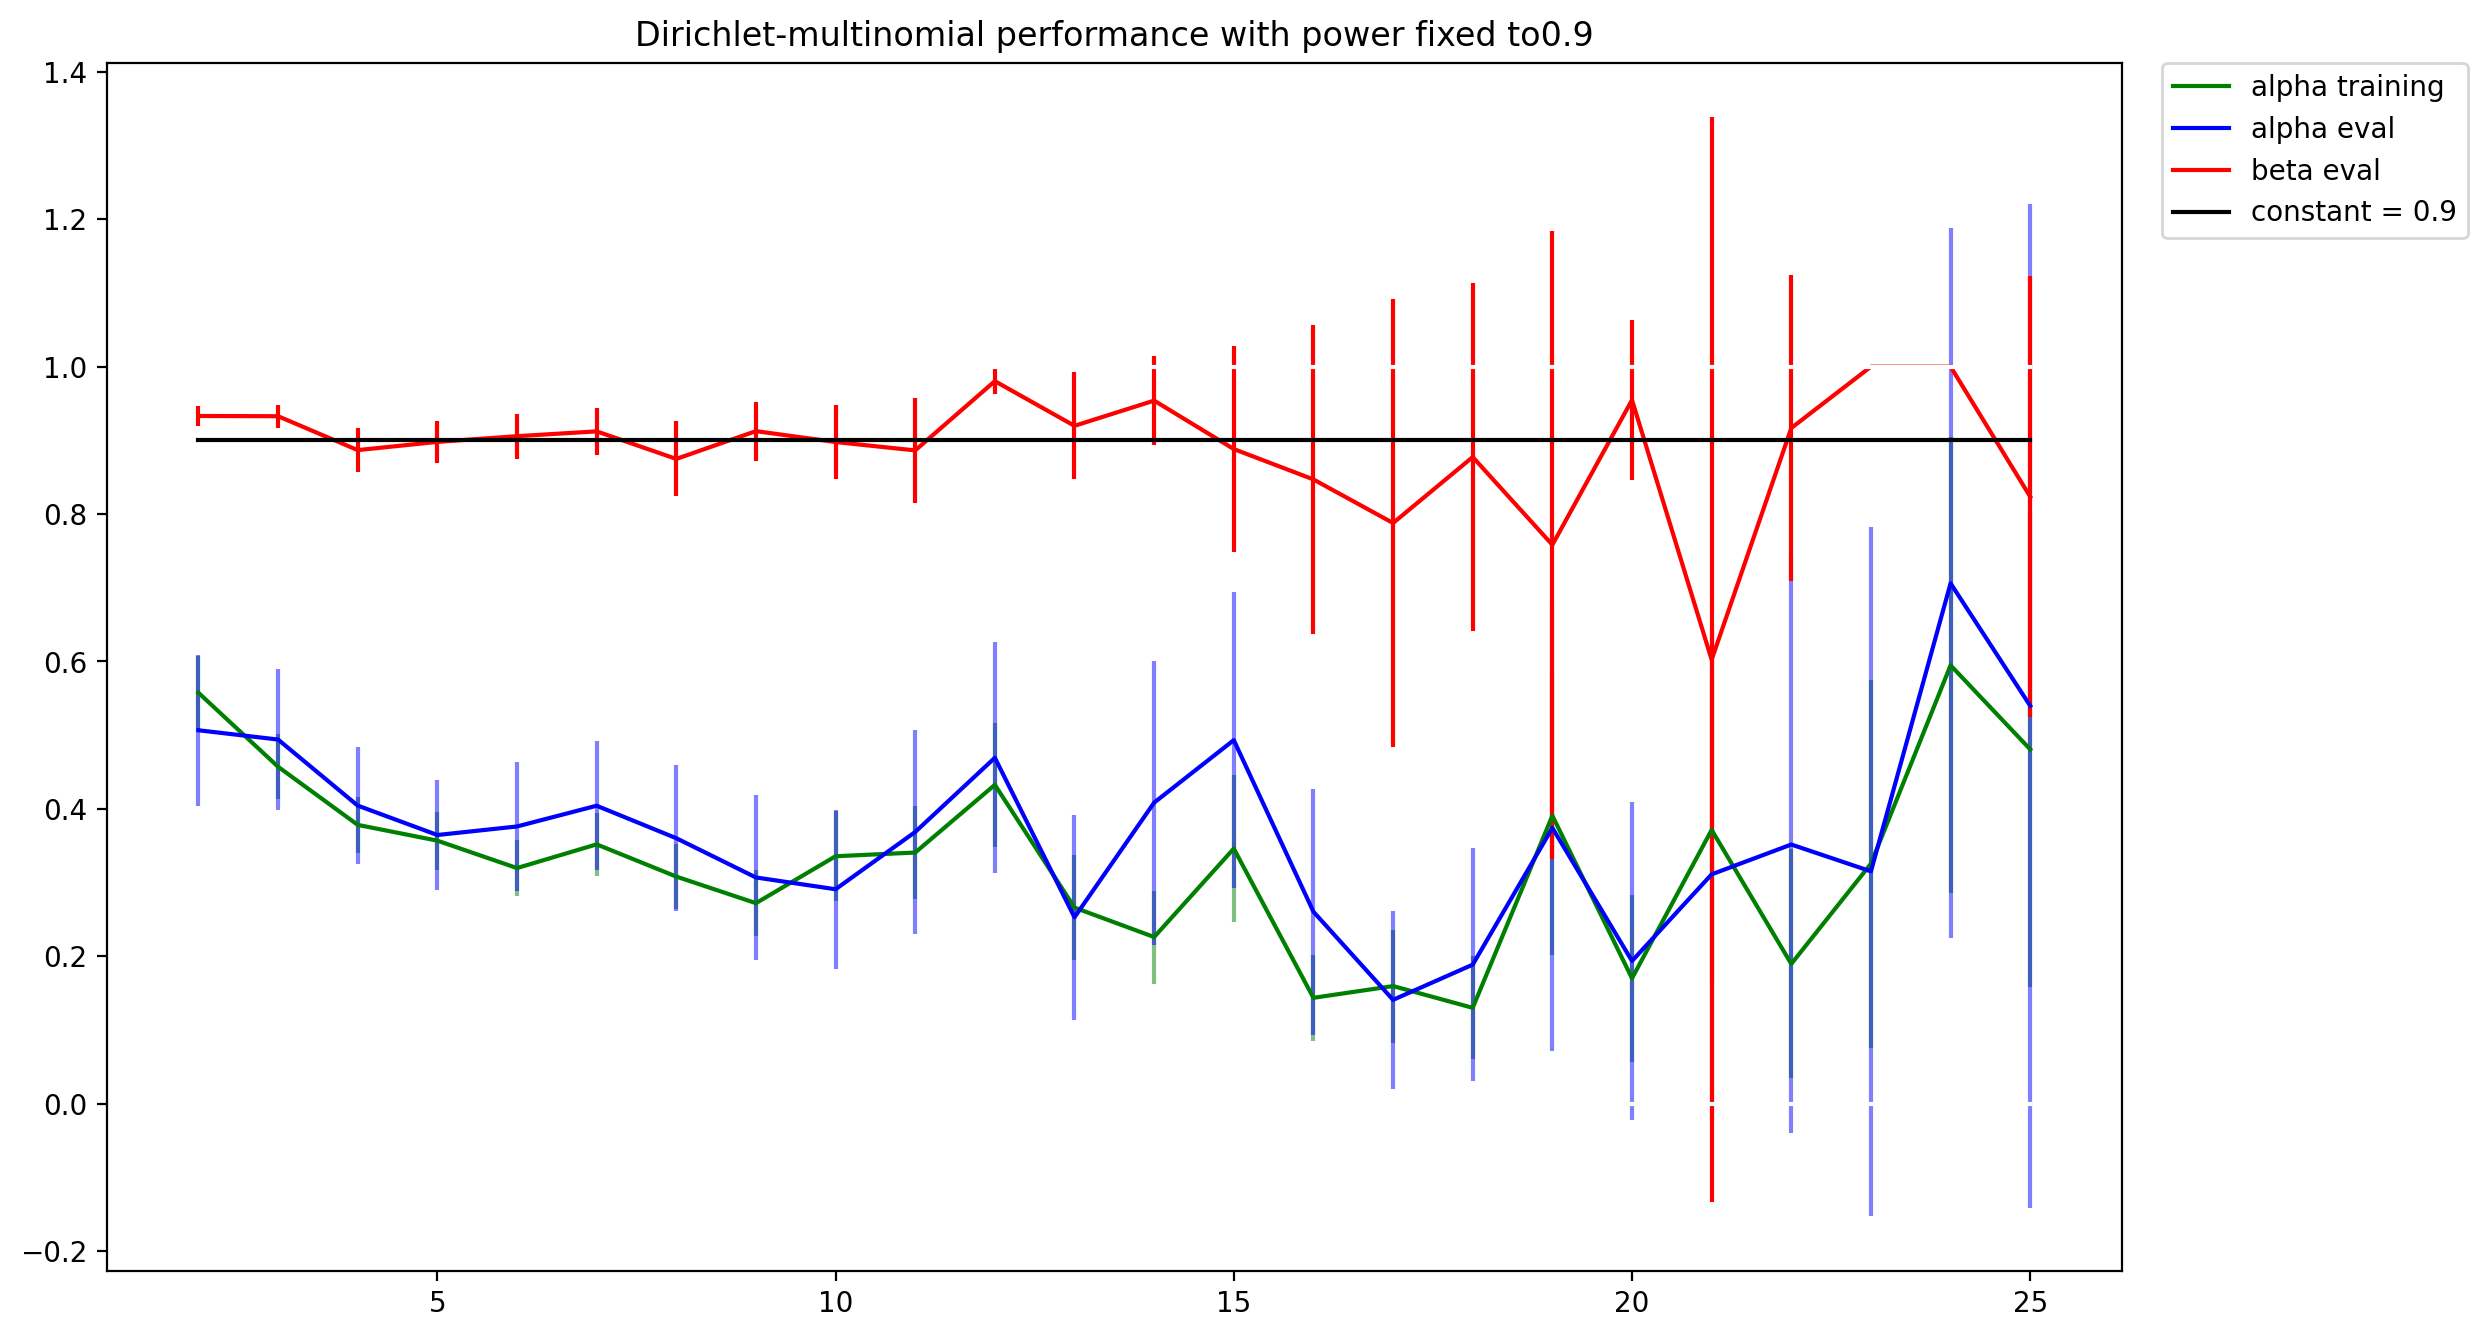

In [15]:
max_col = 26
power = 0.9

plt.figure(figsize = (13, 8))
plt.rcParams["figure.dpi"] = 200

x = np.arange(2, max_col)

type1_training = []
type1_eval = []
type2_eval = []

for nb_col in x:
    phi, th, alpha0, nalpha0 = find_phi_flat(nb_col, power)
    
    beta, alpha, nbeta, nalpha = ev_flat(nb_col, phi, th)
    
    plt.errorbar(nb_col, alpha0, xerr = 0, yerr = alpha0 * (1 - alpha0) / np.sqrt(nalpha0), color = "green", alpha = .5)
    plt.errorbar(nb_col, alpha, xerr = 0, yerr = alpha * (1 - alpha) / np.sqrt(nalpha), color = "blue", alpha = .5)
    plt.errorbar(nb_col, beta, xerr = 0, yerr = beta * (1 - beta) / np.sqrt(nbeta), color = "red")
    
    type1_training.append(alpha0)
    type1_eval.append(alpha)
    type2_eval.append(beta)
    
plt.plot(x, type1_training, color = "green", label = "alpha training")
plt.plot(x, type1_eval, color = "blue", label = "alpha eval")
plt.plot(x, type2_eval, color = "red", label = "beta eval")

plt.plot(x, (max_col - 2) * [0], color = "lightgrey")
plt.plot(x, (max_col - 2) * [1], color = "lightgrey")
plt.plot(x, (max_col - 2) * [power], color = "black", label = "constant = " + str(power))

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.title("Dirichlet-multinomial performance with power fixed to " + str(power))
plt.show()

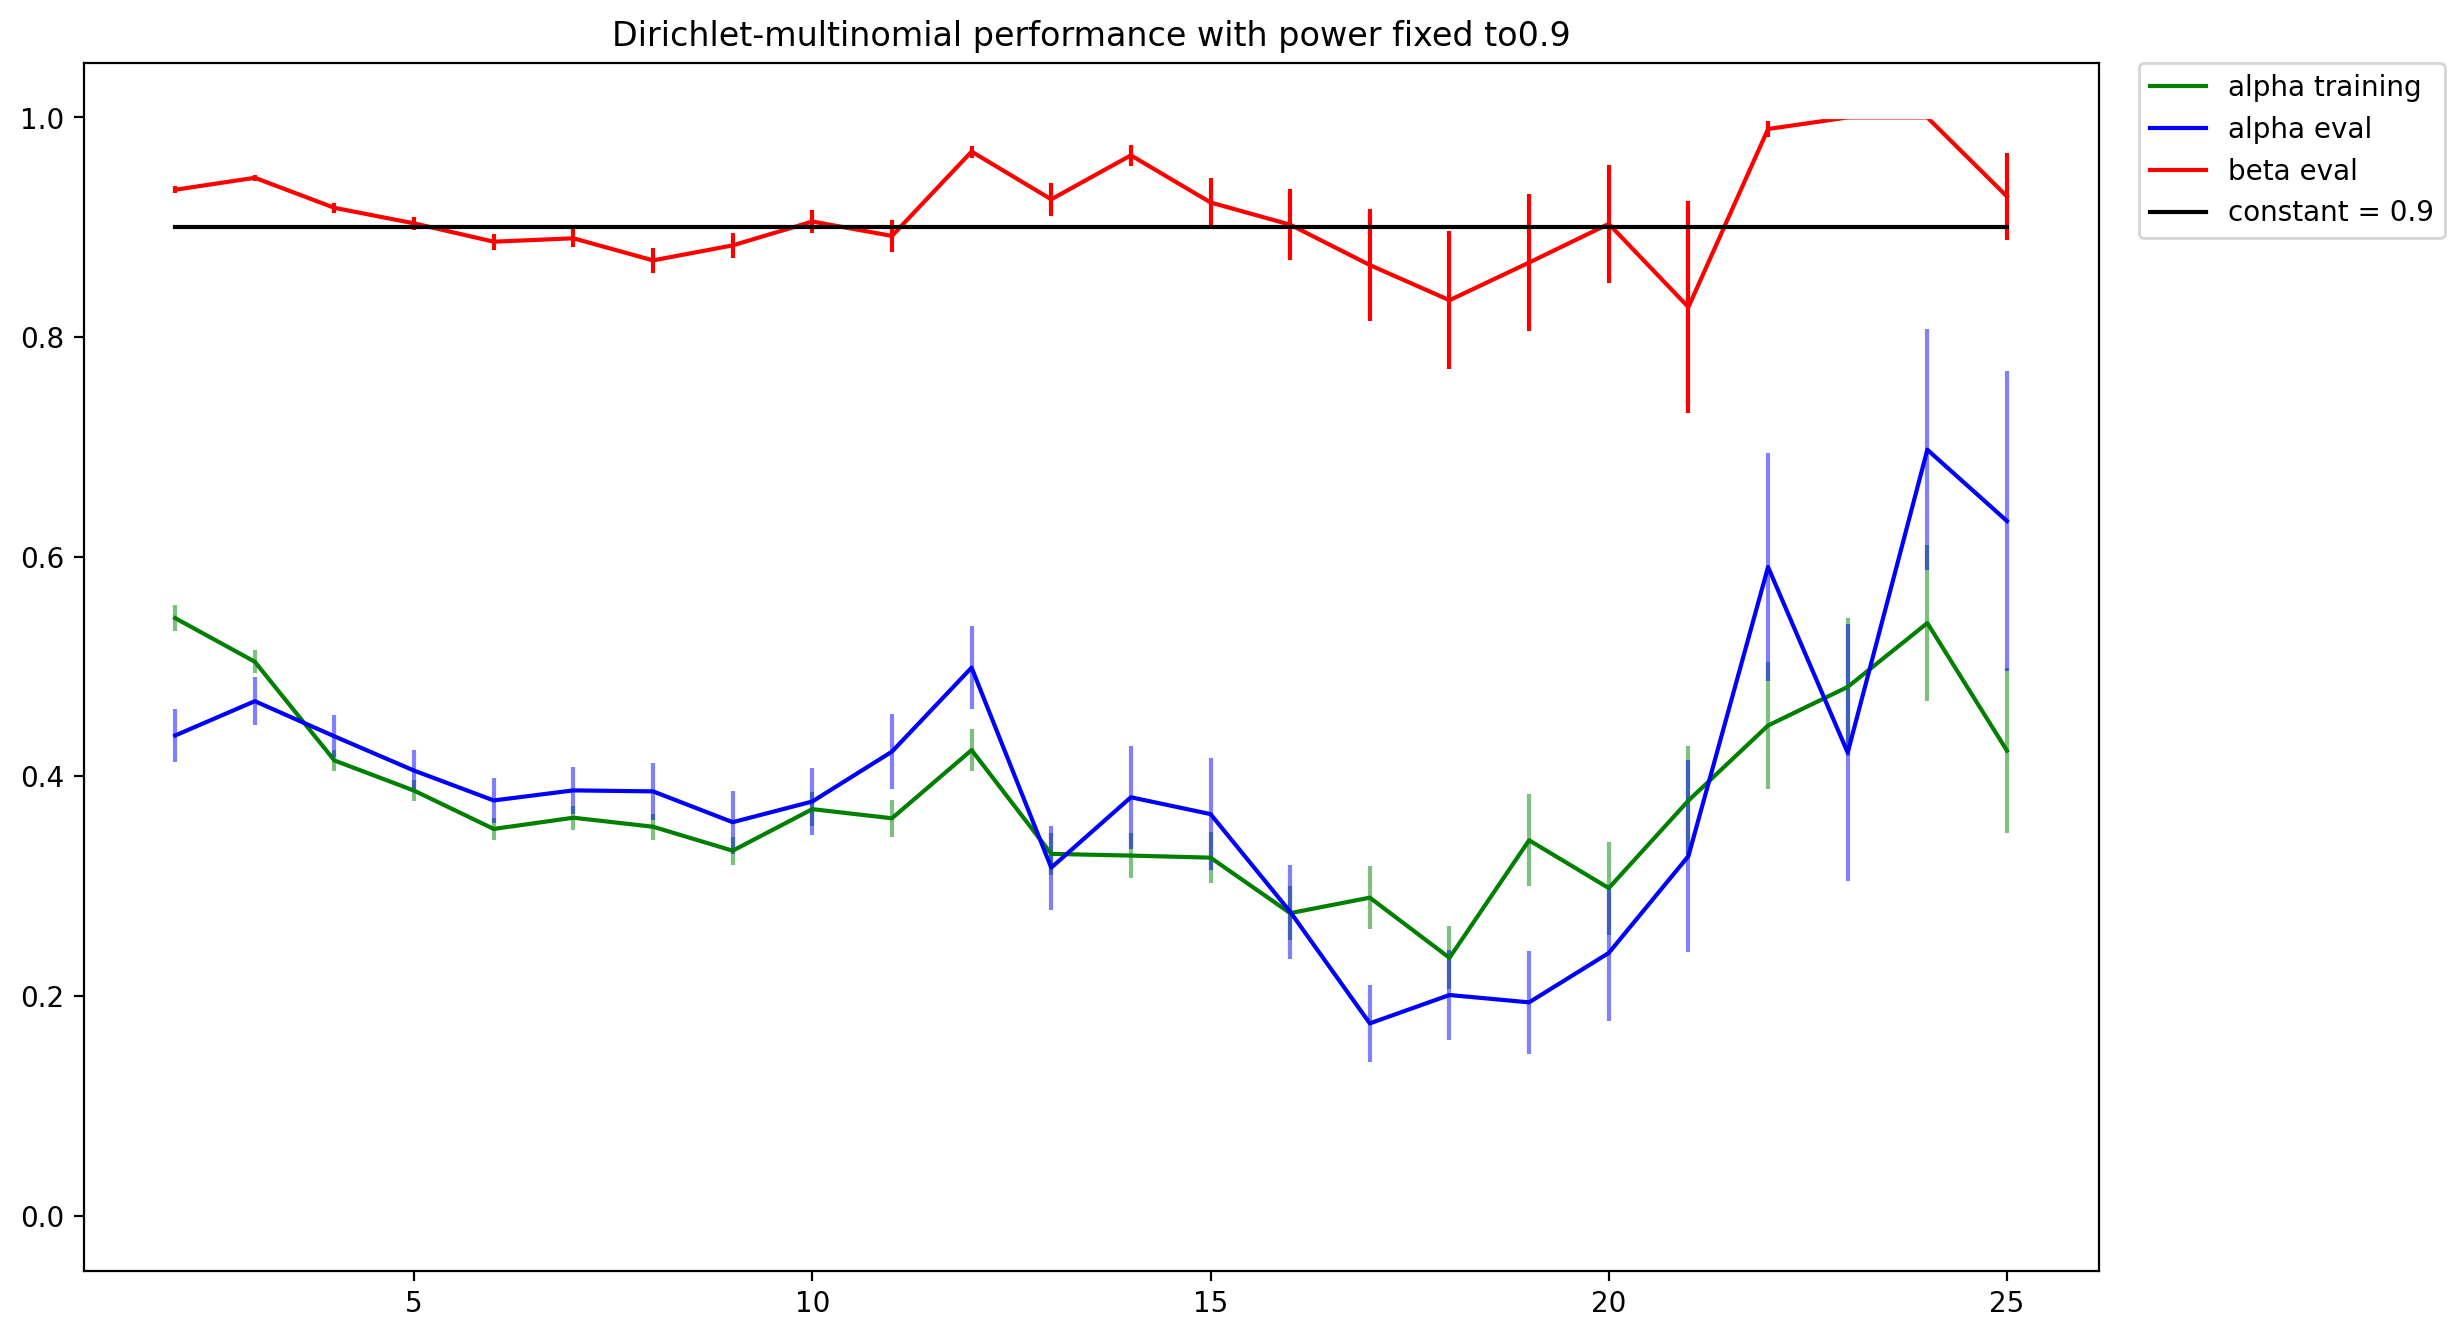

In [18]:
max_col = 26

power = 0.9

plt.figure(figsize = (13, 8))
plt.rcParams["figure.dpi"] = 200

x = np.arange(2, max_col)

type1_training = []
type1_eval = []
type2_eval = []

for nb_col in x:
    phi, th, alpha0, nalpha0 = find_phi_flat2(nb_col, power)
    
    beta, alpha, nbeta, nalpha = ev_flat2(nb_col, phi, th)
    
    plt.errorbar(nb_col, alpha0, xerr = 0, yerr = alpha0 * (1 - alpha0) / np.sqrt(nalpha0), color = "green", alpha = .5)
    plt.errorbar(nb_col, alpha, xerr = 0, yerr = alpha * (1 - alpha) / np.sqrt(nalpha), color = "blue", alpha = .5)
    plt.errorbar(nb_col, beta, xerr = 0, yerr = beta * (1 - beta) / np.sqrt(nbeta), color = "red")
    
    type1_training.append(alpha0)
    type1_eval.append(alpha)
    type2_eval.append(beta)
    
plt.plot(x, type1_training, color = "green", label = "alpha training")
plt.plot(x, type1_eval, color = "blue", label = "alpha eval")
plt.plot(x, type2_eval, color = "red", label = "beta eval")

plt.plot(x, (max_col - 2) * [0], color = "lightgrey")
plt.plot(x, (max_col - 2) * [1], color = "lightgrey")
plt.plot(x, (max_col - 2) * [power], color = "black", label = "constant = " + str(power))

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.title("Dirichlet-multinomial performance with power fixed to " + str(power))
plt.show()

In [90]:
def estp(nb_col, th, phi):
    dmn_diff = pd.DataFrame({"id" : training_beta["str_compound_id"][training_beta["nb_col"] == nb_col],
                             "stat" : [stat_DMN_moments(tb, phi)
                                       for tb in training_beta["tables"][training_beta["nb_col"] == nb_col]
                                      ]
                            })
    
    dmn_diff["bernoulli"] = (dmn_diff["stat"] > th) * np.ones(len(dmn_diff))
    
    sr_pi = dmn_diff.groupby("id")["bernoulli"].mean()
    
    
    a = sr_pi.mean() * (1 - sr_pi.mean())
    b = sr_pi.var()
    
    count_by_id = training_beta.groupby("str_compound_id")["tables"].count()
    weights = np.array([1 / (a + b * count_by_id[i]) for i in dmn_diff["id"]])
    
    return np.sum(weights * dmn_diff["bernoulli"]) / np.sum(weights), a, b, 1 / np.sqrt(np.sum(weights))


    
    
def ev2(nb_col, phi, th, a, b):
    dmn_diff = pd.Series([stat_DMN_moments(tb, phi)
                          for tb in eval_beta["tables"][eval_beta["nb_col"] == nb_col]
                         ])
    
    count_by_id = eval_beta.groupby("str_compound_id")["tables"].count()
    weights_diff = np.array([1 / (a + b * count_by_id[i]) for i in eval_beta["str_compound_id"][eval_beta["nb_col"] == nb_col]])
    total_weight_diff = weights_diff.sum()
    
    return (weights_diff * (dmn_diff > th)).sum() / total_weight_diff, 1 / np.sqrt(total_weight_diff)   